In [1]:
from fastai.vision import *
from inceptionresnet import inceptionresnetv2

In [2]:
import fastai.utils.collect_env
fastai.utils.collect_env.check_perf()

Running performance checks.

*** libjpeg-turbo status
✘ libjpeg-turbo is not on. It's recommended you install libjpeg-turbo to speed up JPEG decoding. See https://docs.fast.ai/performance.html#libjpeg-turbo

*** Pillow-SIMD status
✘ Running Pillow 5.4.1; It's recommended you install Pillow-SIMD to speed up image resizing and other operations. See https://docs.fast.ai/performance.html#pillow-simd

*** CUDA status
❓ Running cpu-only torch version, CUDA check is not relevant

Refer to https://docs.fast.ai/performance.html to make sense out of these checks and suggestions.


In [3]:
torch.cuda.empty_cache()

### Check dataset 

In [4]:
path = Path('data/ILSVRC/Data/CLS-LOC')

In [5]:
os.listdir(path)

['export',
 'imagenet_199px_object_detection.pkl',
 'imagenet_256px_object_detection.pkl',
 'imagenet_299px_object_detection.pkl',
 'models',
 'test',
 'train',
 'valid']

In [6]:
len(os.listdir(path/'train'))

1000

In [7]:
os.listdir(path/'train')[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [8]:
len(os.listdir(path/'valid'))

50000

In [9]:
os.listdir(path/'valid')[:5]

['ILSVRC2012_val_00000001.JPEG',
 'ILSVRC2012_val_00000002.JPEG',
 'ILSVRC2012_val_00000003.JPEG',
 'ILSVRC2012_val_00000004.JPEG',
 'ILSVRC2012_val_00000005.JPEG']

In [10]:
len(os.listdir(path/'test'))

100000

In [11]:
os.listdir(path/'test')[:5]

['ILSVRC2012_test_00000001.JPEG',
 'ILSVRC2012_test_00000002.JPEG',
 'ILSVRC2012_test_00000003.JPEG',
 'ILSVRC2012_test_00000004.JPEG',
 'ILSVRC2012_test_00000005.JPEG']

### for creating the file structure (only valid images because train was correct)

In [12]:
#os.rename(path/'val', path/'valid')
#
#train_classes = os.listdir(path/'train')
#
#for line in open('data/valid.txt'):
#    valid_path = path/'valid'/line.split(' ')[0]
#    valid_class = line.split(' ')[1].replace('\n','')
#    real_class = train_classes[int(valid_class)]
#    if not os.path.isdir(path/'valid'/real_class):
#        os.mkdir(path/'valid'/real_class)
#    os.rename(valid_path, path/'valid'/real_class/line.split(' ')[0])

In [13]:
# could improve performance (not tested with fastai)
torch.backends.cudnn.enabled = True 

### define metric 

In [14]:
def top_5_accuracy(input, targs, k=5):
    return top_k_accuracy(input, targs, k)

## filter by size

### this needs to be run if the databunch is not saved

In [15]:
# 1431167 images in full dataset

In [16]:
#def filter_train_by_size(item):
#    if 'test' in str(item):
#        return False
#    if 'valid' in str(item):
#        return True
#    shape = list(open_image(item).shape)
#    return True if shape[1] > 299 and shape[2] > 299 else False

In [17]:
#filtered = ImageList.from_folder(path).filter_by_func(filter_train_by_size) 

In [18]:
#data_bunch = (filtered.split_by_folder().label_from_folder()) \
#                   .transform(get_transforms(), size=192) \
#                   .databunch(num_workers=8, bs=48) \
#                   .normalize(imagenet_stats)

In [19]:
#data_bunch.save('imagenet_299px_min_train.pkl')

### if the databunch has been saved

In [20]:
#data_bunch = load_data('data/ILSVRC/Data/CLS-LOC', 'imagenet_299px_min.pkl')

In [21]:
#data_bunch.batch_size = 48

### for the full ILSV2017 classification dataset

In [22]:
data_bunch = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=199, num_workers=8, bs=46) \
                           .normalize(imagenet_stats)

C:\Users\chrun\Anaconda3\envs\fastai_updated\lib\site-packages\fastai\data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
valid
  if getattr(ds, 'warn', False): warn(ds.warn)


### quick look at the images

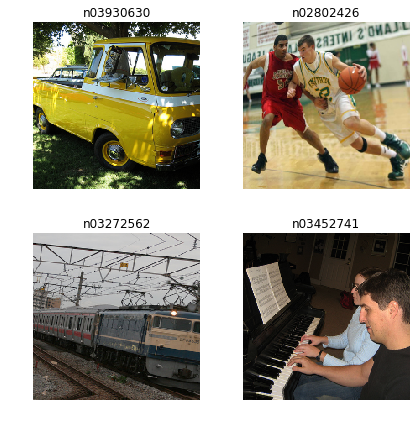

In [23]:
data_bunch.show_batch(rows=2, figsize=(6,6))

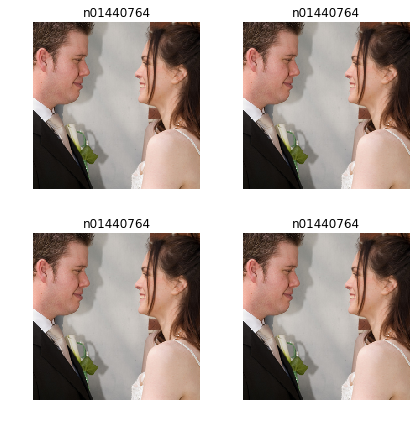

In [24]:
data_bunch.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

### create learner with inceptionresnetv2 (the pytorch model is already pretrained on imagenet)

In [25]:
def inception(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = inceptionresnetv2(pretrained=pretrained)
    return nn.Sequential(*model.children())

In [26]:
learn = cnn_learner(data_bunch, inception, pretrained=True,
                   cut=-2, split_on=lambda m: (m[0][9], m[1]))

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth" to C:\Users\chrun/.torch\models\inceptionresnetv2-520b38e4.pth
223774246it [10:29, 355287.70it/s]


In [ ]:
learn.layer_groups

In [26]:
learn.metrics=[top_5_accuracy, accuracy]

In [29]:
learn.freeze()

In [30]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


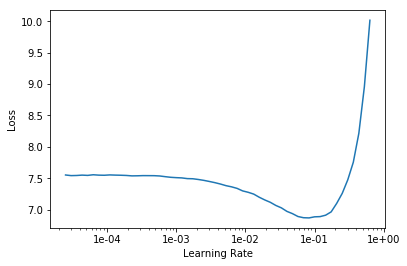

In [32]:
learn.recorder.plot(30)

In [34]:
lr = 1e-2

In [35]:
learn.fit_one_cycle(3, max_lr=slice(lr), div_factor=15)

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,1.283514,1.650091,0.889180,0.713440,2:38:38
1,1.034620,1.339538,0.906840,0.731100,2:38:56
2,0.841354,1.194242,0.918020,0.747380,2:40:00


In [36]:
#learn.save('199px_inceptionresnetv2_frozen');

In [27]:
learn.load('199px_inceptionresnetv2_frozen');

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


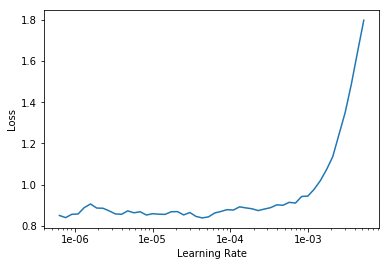

In [30]:
learn.recorder.plot()

In [29]:
lr = 2e-5

In [30]:
lrs = learn.lr_range(slice(lr/9,lr))
lrs

array([2.222222e-06, 6.666667e-06, 2.000000e-05])

In [31]:
learn.fit_one_cycle(3, max_lr=lrs, div_factor=35)

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,0.885950,1.199785,0.917380,0.744280,3:41:37
1,0.810181,1.140927,0.923920,0.754880,3:52:56
2,0.728791,1.129686,0.926040,0.758660,3:54:39
3,0.714266,1.150585,0.924220,0.756980,3:51:12


In [32]:
learn.save('199px_inceptionresnetv2');

### scale up image size to 299

In [44]:
data_bunch = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=299, num_workers=8, bs=16) \
                           .normalize(imagenet_stats)

In [48]:
learn = cnn_learner(data_bunch, inception, pretrained=True,
                   cut=-2, split_on=lambda m: (m[0][9], m[1]))

In [17]:
learn.metrics=[top_5_accuracy, accuracy]

In [18]:
learn.load('199px_inceptionresnetv2');

In [26]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


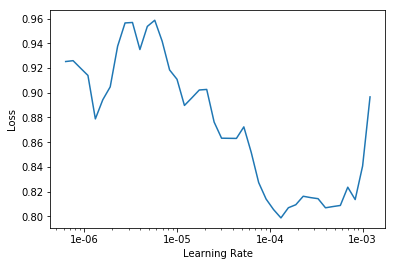

In [29]:
learn.recorder.plot()

In [27]:
lr = 1e-4

In [28]:
lrs = learn.lr_range(slice(lr/27,lr))

In [29]:
lrs

array([3.703704e-06, 1.924501e-05, 1.000000e-04])

In [30]:
learn.fit_one_cycle(2, max_lr=lrs, div_factor=35)

epoch,train_loss,valid_loss,top_5_accuracy,accuracy,time
0,0.611931,1.233685,0.938100,0.778920,11:17:30
1,0.475397,1.210095,0.942600,0.793460,11:19:38


In [31]:
#learn.save('299px_inceptionresnetv2')

In [49]:
learn.load('299px_inceptionresnetv2');

In [27]:
interpr = learn.interpret()

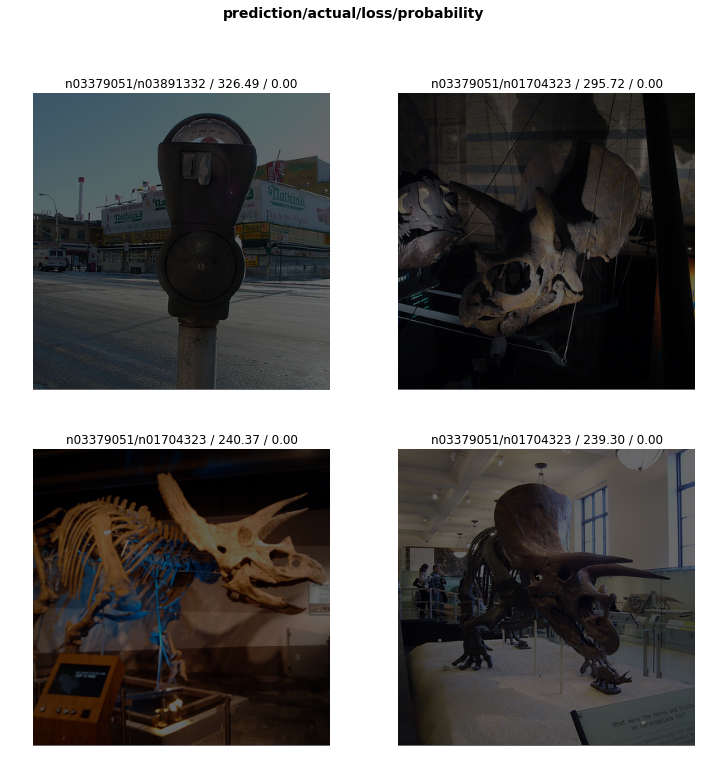

In [30]:
interpr.plot_top_losses(4, figsize=(12,12))

## prediction 

In [19]:
path

PosixPath('data/ILSVRC/Data/CLS-LOC')

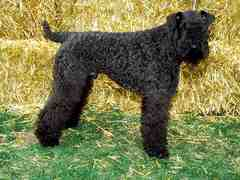

In [20]:
img = open_image(path/'train/n02093859/n02093859_1049.JPEG')
img

In [21]:
cl, label, prob = learn.predict(img)

In [22]:
cl, label #, prob

(Category n02093859, tensor(183))

In [23]:
# Load Imagenet Synsets
with open('data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

# len(synsets)==1001
# sysnets[0] == background
synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

In [24]:
{k: key_to_classname[k] for k in list(key_to_classname)[:5]}

{'?????????': 'dummy class for index 0',
 'n02119789': 'kit fox, Vulpes macrotis',
 'n02100735': 'English setter',
 'n02110185': 'Siberian husky',
 'n02096294': 'Australian terrier'}

In [25]:
key_to_classname[str(cl)]

'Kerry blue terrier'

In [50]:
learn.export('inceptionresnetv2.pkl')

In [33]:
learn.path

PosixPath('data/ILSVRC/Data/CLS-LOC')

In [48]:
learn = load_learner(path=path/'export', file='export.pkl')